In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from scipy.stats import norm
from math import log, sqrt, exp


In [2]:
spy = yf.Ticker('SPY')
df = spy.history(period="5y")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-10-16 00:00:00-04:00,433.820007,437.140015,433.570007,436.040009,75433200,0.0,0.0,0.0
2023-10-17 00:00:00-04:00,432.809998,438.140015,432.450012,436.019989,75324700,0.0,0.0,0.0
2023-10-18 00:00:00-04:00,434.190002,435.179993,429.089996,430.209991,93559800,0.0,0.0,0.0
2023-10-19 00:00:00-04:00,430.950012,432.820007,425.730011,426.429993,121323000,0.0,0.0,0.0
2023-10-20 00:00:00-04:00,425.980011,426.540009,421.079987,421.190002,123845800,0.0,0.0,0.0


In [3]:
#Geometric Brownian Motion

logreturns = np.log(df.Close/df.Close.shift(1))
sigma = np.std(logreturns, ddof = 1)
mu = np.mean(logreturns) + 0.5*sigma**2
sigma

0.013549128212443189

C:\Users\Wei\AppData\Local\Temp\ipykernel_41740\3907331290.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stock_price_paths[i, t] = stock_price_paths[i, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)


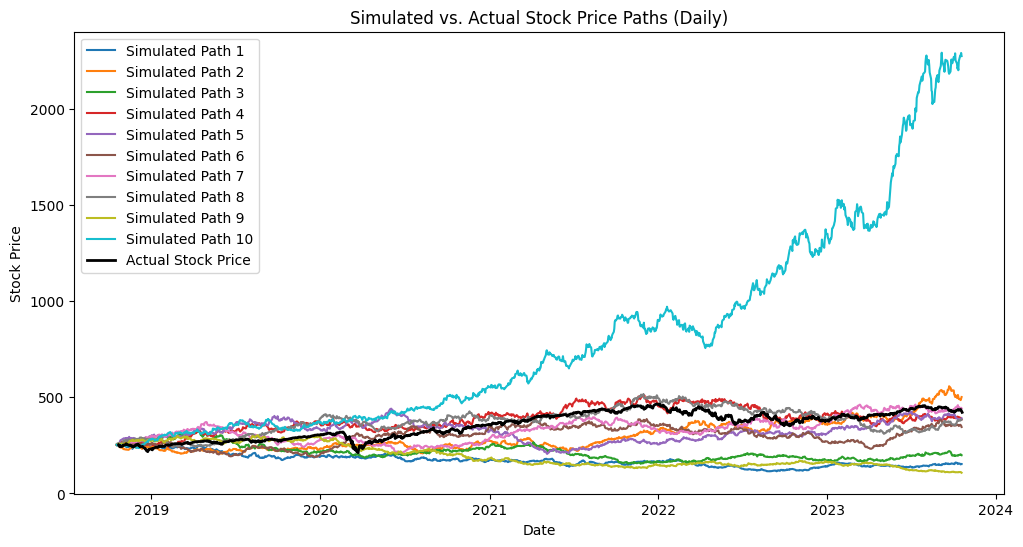

In [4]:
# Generate Geometric Brownian Motion paths

S0 = df['Close'].iloc[0] 
years = 5  
trading_days_per_year = 252  
num_paths = 10 
sigma = np.std(logreturns, ddof = 1)
mu = np.mean(logreturns) + 0.5*sigma**2

N = years * trading_days_per_year + 45
dt = 1
stock_price_paths = np.zeros((num_paths, N + 1))
stock_price_paths[:, 0] = S0

for i in range(num_paths):
    for t in range(1, N + 1):
        z = np.random.standard_normal(1)
        stock_price_paths[i, t] = stock_price_paths[i, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

actual_stock_prices = df.iloc[:, [3]]   
date_range = pd.date_range(start='2018-10-18', periods=N + 1, freq='B')  # Adjust the start date as needed

plt.figure(figsize=(12, 6))
for i in range(num_paths):
    plt.plot(date_range, stock_price_paths[i], label=f'Simulated Path {i + 1}')
plt.plot(actual_stock_prices.index, actual_stock_prices['Close'], label='Actual Stock Price', color='black', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Simulated vs. Actual Stock Price Paths (Daily)")
plt.legend()
plt.show()


In [5]:
#2.3 Using Geometric Brownian Motion to calculate call price
#Using mu and sigma from GBM

In [6]:
T = 30 #days to maturity
K = 445
S0 = 436.04 #Stock price at 17 Oct 2023
r = 0.0471/365 #Daily riskfree rate

def European_Call(S, K, r, T):
  if S > K:
    payoff = S - k
  elif S < K:
    payoff = 0
  return payoff

def d1(S, K, r, sigma, T):
  dis = (log(S/K)+T*(r+0.5*(pow(sigma, 2))))/(sigma*pow(T,0.5))
  return dis

def d2(S, K, r, sigma, T):
  dis = (log(S/K)+T*(r-0.5*(pow(sigma, 2))))/(sigma*pow(T,0.5))
  return dis

def bs_model(S, K, r, sigma, T, optionType):
  if optionType == "Call":
    payoff = S*norm.cdf(d1(S,K,r,sigma,T),0,1) - K*exp(-r*T)*norm.cdf(d2(S,K,r,sigma,T),0,1)
  return payoff


In [7]:
# Option price using Black Scholes Model
BS_price = bs_model(S0, K, r, sigma, T, "Call")
print("The binomial option price is", BS_price)

The binomial option price is 9.712338801104949


In [ ]:
#2.4 Using Geometric Brownian Motion to calculate call price 
#Using mu and sigma from GBM

In [13]:
def Binomial(S, K, r, sigma, T, N):
  u = exp(sigma*pow(T/N,0.5))
  d = 1/u
  q = (exp(r*T/N) - d)/(u - d)
  dt = T/N
  df = exp(-r*T/N)
  NodeList = [None]*(N+1)
    
  # Calculation of the payoff of final (Nth) steps Payoff
  Ending_Node_Payoff = np.asarray([(S*pow(u,i)*pow(d,N-i)) for i in range(N+1)])

  # Declaration of a Dynamic array:
  #Array(NodePnL) will be used for loop later; the size of the array will decrease by 1 in every loop 
  NodePnL = np.maximum(Ending_Node_Payoff - K, 0)

  # Save the payoff of last step into NodeList
  NodeList[-1] = NodePnL
  for i in range(N,0,-1):
    NodePnL=df*(q*NodePnL[1:] + (1-q)*NodePnL[:-1])
    NodeList[i-1] = NodePnL

  return NodeList[0][0]


In [16]:
bin_price = Binomial(S0, K, r, sigma, T, 300)
print("The binomial option price is", bin_price)

The binomial option price is 9.714771998398167


In [22]:
N_Step_list = [1,5,10,25,50,100,250,500,1000,3000,5000]
N_Step_df = [None]*len(N_Step_list)
BS_df = [BS_price for i in range(len(N_Step_list))]
for i, j in enumerate(N_Step_list):
  output = Binomial(S0, K, r, sigma, T, j)
  N_Step_df[i] = output
  print("Options price using Binomial Tree with ",j," steps is :",output)

Options price using Binomial Tree with  1  steps is : 12.444822875672642
Options price using Binomial Tree with  5  steps is : 9.86813812046434
Options price using Binomial Tree with  10  steps is : 10.000150178476163
Options price using Binomial Tree with  25  steps is : 9.724978569270945
Options price using Binomial Tree with  50  steps is : 9.655492865564174
Options price using Binomial Tree with  100  steps is : 9.732072571887956
Options price using Binomial Tree with  250  steps is : 9.7068914179121
Options price using Binomial Tree with  500  steps is : 9.70248826900075
Options price using Binomial Tree with  1000  steps is : 9.708323536401252
Options price using Binomial Tree with  3000  steps is : 9.706980740658949
Options price using Binomial Tree with  5000  steps is : 9.70638206352086


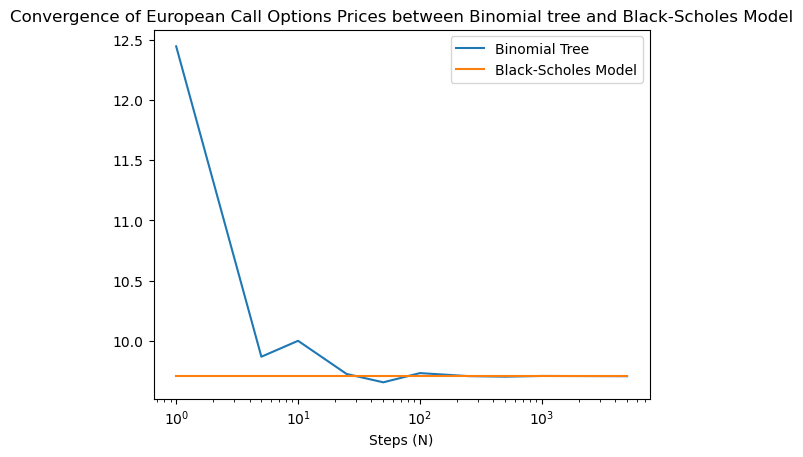

In [23]:
plt.plot(N_Step_list, N_Step_df, label = "Binomial Tree")
plt.plot(N_Step_list, BS_df, label = "Black-Scholes Model")
plt.legend()
plt.xlabel("Steps (N)")
plt.xscale("log")
plt.title("Convergence of European Call Options Prices between Binomial tree and Black-Scholes Model")
plt.show()

In [ ]:
#This shows that as the number of steps in the Binomial model increased and computational time increase, the accuracy can also be increased and the binomial option price will tend towards the Black Scholes formula 